I want to create another column that says whether a certain site failure overlapped with others

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Final_Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)
wq_df['Sampling Location'] = wq_df['Sampling Location'].astype('category')

Having graph showing overlapping failures does not give me additional information on when sites fail in respect to each other. The most highly connected sites in the graph are also the most frequent ones that fail which makes sense. I want to now make a new dataframe that illustrates these connections more completely.

In [2]:
def site_fail_col(df, site, col):
    '''Creates a list of binary responses to whether the measurement failed (1) test \'col\' or not (0)
        in reference to the date of the original \'site\' sample.
        df  = pandas DataFrame from which to draw all data
        site = sampling location being tested. When site fails, what other sites fail?
        col = parameter being tested
        '''
    column = col + ' Failure'
    fail_date_df = df[(df['Sampling Location'] == site) & (df[column] == 1)]['Sample Date']
    site_set = set([(i.year, i.month) for i in fail_date_df])
    
    site_col_overlap = []
    
    # Checks to see if sample date is in set of dates where `site` failed  
    # if failures overlap, appends 1 to site_col_overlap
    for tup in df.itertuples():
        if (tup[42] == 1) & ((tup[2].year, tup[2].month) in site_set):
            site_col_overlap.append(1)
        else:
            site_col_overlap.append(0)
    
    return site_col_overlap

In [ ]:
def site_fail_col(df, site, col):
    '''Creates a list of binary responses to whether the measurement failed (1) test \'col\' or not (0)
        in reference to the date of the original \'site\' sample.
        df  = pandas DataFrame from which to draw all data
        site = sampling location being tested. When site fails, what other sites fail?
        col = parameter being tested
        '''
    column = col + ' Failure'
    fail_date_df = df[(df['Sampling Location'] == site) & (df[column] == 1)]['Sample Date']
    site_set = set([(i.year, i.month) for i in fail_date_df])
    
    site_col_overlap = []
    
    # Checks to see if sample date is in set of dates where `site` failed  
    # if failures overlap, appends 1 to site_col_overlap
    for tup in df.itertuples():
        if (tup[42] == 1) & ((tup[2].year, tup[2].month) in site_set):
            site_col_overlap.append(1)
        else:
            site_col_overlap.append(0)
    
    return site_col_overlap

In [3]:
from tqdm import tqdm

chl_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_chl'
    site_list = site_fail_col(wq_df, site, 'Top Active Chlorophyll \'A\' (µg/L)')
    
    chl_overlap_df[col_name] = site_list

    
ent_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_ent'
    site_list = site_fail_col(wq_df, site, 'Top Enterococci Bacteria (Cells/100mL)')
    
    ent_overlap_df[col_name] = site_list


pho_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_pho'
    site_list = site_fail_col(wq_df, site, 'Top Ortho-Phosphorus (mg/L)')
    
    pho_overlap_df[col_name] = site_list


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.06it/s]


For these graphs, the site along the x-axis is the one who's prediction ability we are testing. If site_x fails, then what is the probability that site_y fails too. I made it so the sum of each row and column had to be greater than 1 so if site_x fails, at least 1 of the shown sites should fail as well.

(16, 26)


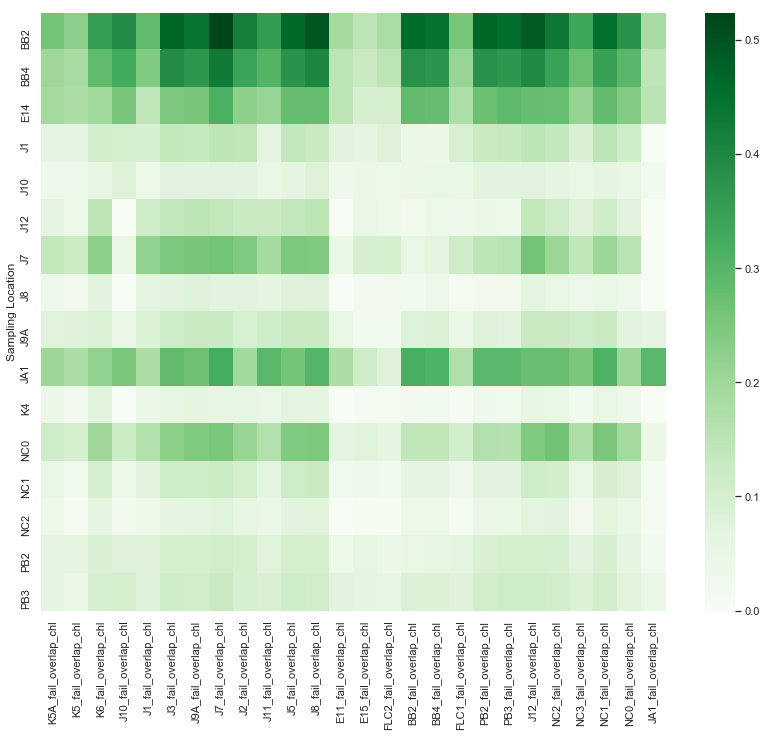

In [4]:
chl_means_df = chl_overlap_df.groupby('Sampling Location').mean()
for i, row in chl_means_df.iterrows():
    if row.sum() <= 1:
        chl_means_df = chl_means_df.drop(index=[i])

for col in chl_means_df:
    if chl_means_df[col].sum() <= 1:
        chl_means_df = chl_means_df.drop(columns=[col])
        
print(chl_means_df.shape)    
_ = plt.figure(figsize=(14, 11))
_ = sns.heatmap(data=chl_means_df, cmap='Greens')

(13, 16)


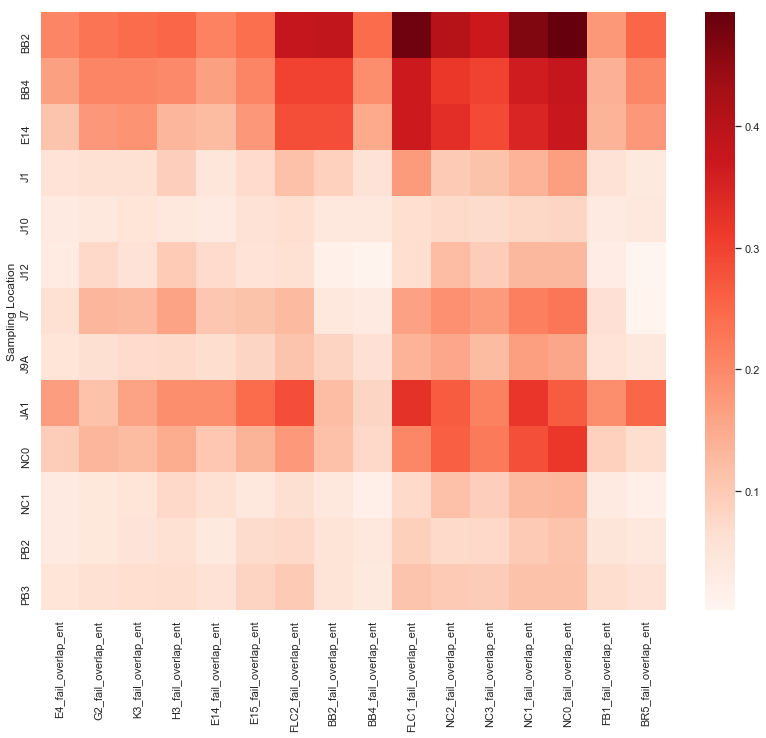

In [5]:
ent_means_df = ent_overlap_df.groupby('Sampling Location').mean()
for i, row in ent_means_df.iterrows():
    if row.sum() <= 1:
        ent_means_df = ent_means_df.drop(index=[i])
for col in ent_means_df:
    if ent_means_df[col].sum() <= 1:
        ent_means_df = ent_means_df.drop(columns=[col])
print(ent_means_df.shape)
_ = plt.figure(figsize=(14, 11))
_ = sns.heatmap(data=ent_means_df, cmap='Reds')

(15, 14)


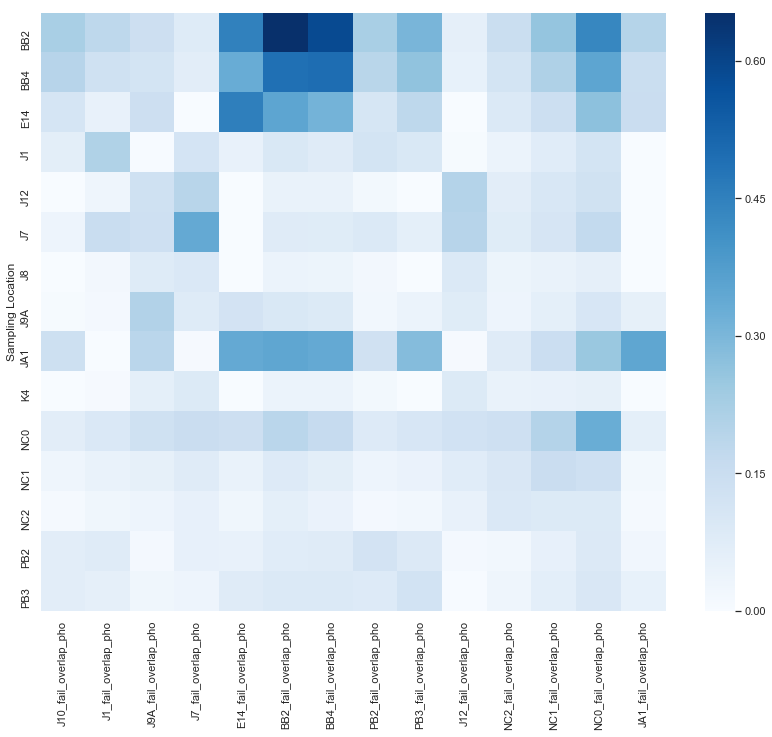

In [6]:
pho_means_df = pho_overlap_df.groupby('Sampling Location').mean()
for i, row in pho_means_df.iterrows():
    if row.sum() <= 1:
        pho_means_df = pho_means_df.drop(index=[i])
for col in pho_means_df:
    if pho_means_df[col].sum() <= 1:
        pho_means_df = pho_means_df.drop(columns=[col])
print(pho_means_df.shape)
_ = plt.figure(figsize=(14, 11))
_ = sns.heatmap(data=pho_means_df, cmap='Blues')

I am going to take the top 10 sites from the phosphate heatmap based on the sum of their probabilities and develop a geospatial representation of their likelihoods. 

Main Goal:

-Create Kriging visualization using pykrige

In [7]:
pho_means_df.sum(axis=0).sort_values(ascending=False)[:10]

BB2_fail_overlap_pho    2.752098
NC0_fail_overlap_pho    2.688822
BB4_fail_overlap_pho    2.556063
E14_fail_overlap_pho    2.095366
NC1_fail_overlap_pho    1.772766
PB3_fail_overlap_pho    1.624444
J9A_fail_overlap_pho    1.477483
J7_fail_overlap_pho     1.452636
PB2_fail_overlap_pho    1.273962
NC2_fail_overlap_pho    1.131586
dtype: float64

In order to perform kriging, data has to be normal. I transform the numeric value of Ortho-phosphorus using np.log.

In [8]:
krige_df = wq_df[wq_df['Sampling Location'].isin(['BB2', 'NC0', 'BB4',
                                                  'E14', 'NC1', 'PB3',
                                                  'J9A', 'J7', 'PB2',
                                                  'NC2'])]
krige_df = krige_df.select_dtypes([np.int64, np.float64])
krige_df = krige_df.drop(columns=['Top Ortho-Phosphorus (mg/L) Failure'])
krige_df['Top Ortho-Phosphorus (mg/L)'] = krige_df['Top Ortho-Phosphorus (mg/L)'].apply(np.log)

In [9]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1, gamma='scale')
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]



p = np.array(krige_df.drop(columns=['Lat', 'Long', 'Top Ortho-Phosphorus (mg/L)']))
x = np.array(krige_df.loc[:, ['Lat', 'Long']])
target = np.array(krige_df.loc[:, 'Top Ortho-Phosphorus (mg/L)'])

p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

fitted_models = dict()
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    fitted_models[m.__class__.__name__] = m_rk
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))


regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.008969129484290184
RK score:  0.038294802952512974
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.6218396590931596
RK score:  0.6315555881471302
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Regression Score:  0.3155264398676777
RK score:  0.3026610187927392


Based on these scores, the best model is the Random Forest Regressor as it has the highest Regression Score. Approximately 64% of the variance is explained with this model.

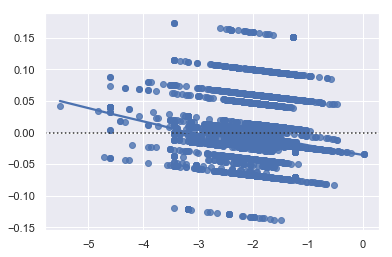

In [10]:
residuals = fitted_models['RandomForestRegressor'].krige_residual(x)
_ = sns.residplot(target, residuals, lowess=True)

I want to now do this with the binary classifier and see what the regression results look like.

In [11]:
krige_df = wq_df[wq_df['Sampling Location'].isin(['BB2', 'NC0', 'BB4',
                                                  'E14', 'NC1', 'PB3',
                                                  'J9A', 'J7', 'PB2',
                                                  'NC2'])]
krige_df = krige_df.select_dtypes([np.int64, np.float64])
krige_df = krige_df.drop(columns=['Top Ortho-Phosphorus (mg/L)'])

In [12]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1, gamma='scale')
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]



p = np.array(krige_df.drop(columns=['Lat', 'Long', 'Top Ortho-Phosphorus (mg/L) Failure']))
x = np.array(krige_df.loc[:, ['Lat', 'Long']])
target = np.array(krige_df.loc[:, 'Top Ortho-Phosphorus (mg/L) Failure'])

p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

fitted_models = dict()
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    fitted_models[m.__class__.__name__] = m_rk
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))


regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.11944670346123896
RK score:  0.09050353826806501
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.4849005631225144
RK score:  0.4952583283496991
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Regression Score:  0.14665795328330433
RK score:  0.1661122414967119


The Random Forest Regressor is still the best classifier, but I want to inspect the predicted values.

In [13]:
rf_rk = RegressionKriging(regression_model=rf_model, n_closest_points=10)
rf_rk.fit(p_train, x_train, target_train)
target_pred = rf_rk.predict(p_test, x_test)

Finished learning regression model
Finished kriging residuals


While my model has very high accuracy, but since it is unbalanced, it is not fair to use accuracy as the metric. I will look at F1 score instead which takes into account false positives and negatives as well.

In [14]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
print('Accuracy: ', accuracy_score(target_test, (target_pred > 0.5)))
print('F1 Score: ',f1_score(target_test, (target_pred > 0.5)))
print(classification_report(target_test, (target_pred > 0.5)))


Accuracy:  0.8693508627773213
F1 Score:  0.7336683417085427
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       902
           1       0.78      0.70      0.73       315

    accuracy                           0.87      1217
   macro avg       0.84      0.81      0.82      1217
weighted avg       0.87      0.87      0.87      1217



I am creating a dataframe containing information on where each location failure overlaps with failures of another site. I am looking at phosphate in this dataframe. My intention is to iterate through each of the 

In [15]:
full_overlap_df_pho = wq_df.join(pho_overlap_df, rsuffix='_r')
full_overlap_df_pho.drop(columns=['Sampling Location_r', 'Sample Time',
                                  'Sample Date', 'Sampling Location'], inplace=True)

Create a dictionary

{site_fail_overlap:{model_a:{fitted_model,
                             \[y_pred\],
                             f1:score,
                             }
                    model_b:{fitted_model,
                             \[y_pred\],
                             f1:score,
                             }
                    model_c:{fitted_model,
                             \[y_pred\],
                             f1:score,
                             }
                    }
 }

## Take binary overlap results and predict other locations

I will select 5 sites to perform this testing on. They will be `K4`, `J7`, `BB2`, `NC0`, and `JA1`.

In [16]:
def balance(df, site):
    '''Resamples dataset to balance target variable categorizations.'''
    
    target = site + '_fail_overlap_pho'
    int_df = df.select_dtypes(include=[float, 'int64'])
    int_df = int_df.drop(columns=['Lat', 'Long'])
    
    class0 = int_df[int_df[target] == 0]
    class1 = int_df[int_df[target] == 1]
    nclass0 = len(class0)
    nclass1 = len(class1)
    class0_resampled = np.random.choice(class0.index, size=2000, replace=True)
    class1_resampled = np.random.choice(class1.index, size=2000, replace=True)
    resampled_int_df = int_df.iloc[class0_resampled]
    resampled_int_df = resampled_int_df.append(int_df.iloc[class1_resampled])
    
    return resampled_int_df

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

site_list = ['K4', 'J7', 'BB2', 'NC0', 'JA1']

#svc_model = SVC(C=0.1, gamma='scale')
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression()

models = [rf_model, lr_model]

balanced_overlap_df_pho = balance(full_overlap_df_pho, 'K4')

x = balanced_overlap_df_pho.iloc[:, :40]
target = balanced_overlap_df_pho.loc[:, 'K4_fail_overlap_pho']

x_train, x_test, target_train, target_test \
    = train_test_split(x, target, test_size=0.3, random_state=42)



In [18]:
x

,Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),Top Salinity (psu),Bottom Salinity (psu),Top Conductivity (S/m),Bottom Conductivity (S/m),"CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)",...,Top Active Chlorophyll 'A' (µg/L) Failure,"CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure",Top Enterococci Bacteria (Cells/100mL) Failure,Top Fecal Coliform Bacteria (Cells/100mL) Failure,Top Total Kjeldhal Nitrogen (mg/L) Failure,Top PH Failure,Top Ortho-Phosphorus (mg/L) Failure,Month,E8_fail_overlap_pho,E7_fail_overlap_pho
12606,24.28,24.03,18.0,3.0,16.0,23.84,24.64,3.71,3.80,4.24,...,0,0,0,0,0,0,0,8,0,0
12329,25.25,21.90,53.0,3.0,50.0,19.01,27.55,3.08,4.03,5.96,...,0,0,0,0,0,0,0,7,0,0
2322,20.20,19.38,24.0,4.0,24.0,23.22,24.07,3.33,3.38,9.51,...,0,0,0,0,0,0,0,7,0,0
2563,21.01,17.23,14.0,3.0,11.0,25.52,25.48,3.69,3.39,6.57,...,0,0,0,0,0,0,0,9,0,0
22475,21.82,21.77,54.0,3.0,47.0,23.82,23.90,3.50,3.53,5.26,...,0,0,0,0,0,0,0,7,0,0
20637,28.13,26.73,13.0,3.0,10.0,26.55,27.09,4.40,4.37,13.93,...,0,0,0,0,0,0,0,7,0,0
12218,19.96,19.40,38.0,3.0,35.0,28.37,28.89,3.97,3.99,4.95,...,0,0,0,0,0,0,1,6,0,0
8474,26.55,24.90,23.0,3.0,22.0,22.08,25.12,3.62,3.94,12.27,...,1,0,0,0,0,0,1,8,0,0
7377,22.24,21.27,88.0,3.0,80.0,25.20,26.54,3.74,3.84,2.46,...,0,1,0,0,0,0,0,8,0,0
15559,23.38,23.26,24.0,3.0,21.0,22.14,23.44,3.41,3.58,4.56,...,0,0,1,1,0,0,0,8,0,0


In [19]:
for m in models:
    m.fit(x_train, target_train)
    target_pred = m.predict(x_test)
    print(classification_report(target_pred, target_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       606
           1       1.00      0.97      0.99       594

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       593
           1       1.00      0.95      0.97       607

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



In [31]:
rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
lat = wq_df.groupby('Sampling Location')['Lat'].mean()
long = wq_df.groupby('Sampling Location')['Long'].mean()


In [29]:
joined_df = pho_means_df.join(lat)
joined_df = joined_df.join(long)

In [41]:
joined_df.columns

Index(['J10_fail_overlap_pho', 'J1_fail_overlap_pho', 'J9A_fail_overlap_pho',
       'J7_fail_overlap_pho', 'E14_fail_overlap_pho', 'BB2_fail_overlap_pho',
       'BB4_fail_overlap_pho', 'PB2_fail_overlap_pho', 'PB3_fail_overlap_pho',
       'J12_fail_overlap_pho', 'NC2_fail_overlap_pho', 'NC1_fail_overlap_pho',
       'NC0_fail_overlap_pho', 'JA1_fail_overlap_pho', 'Lat', 'Long'],
      dtype='object')

In [42]:
joined_df.shape

(15, 16)

Making an Inverse Distance Weighted map using NC0 failure overlap.

C:\Users\Drew\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Drew\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


(2500,)


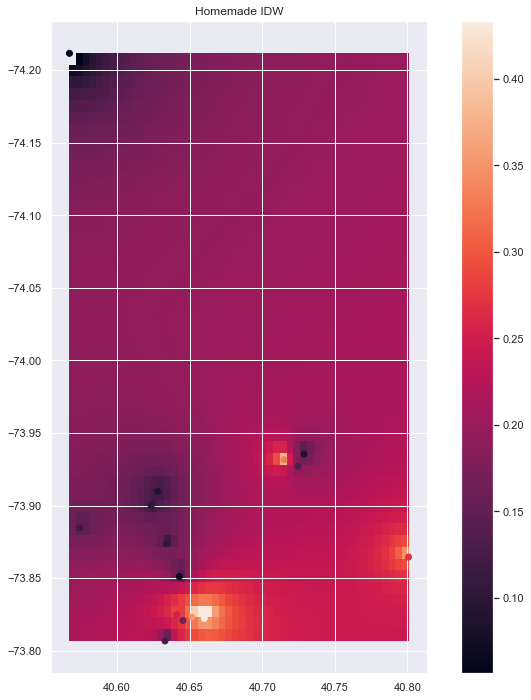

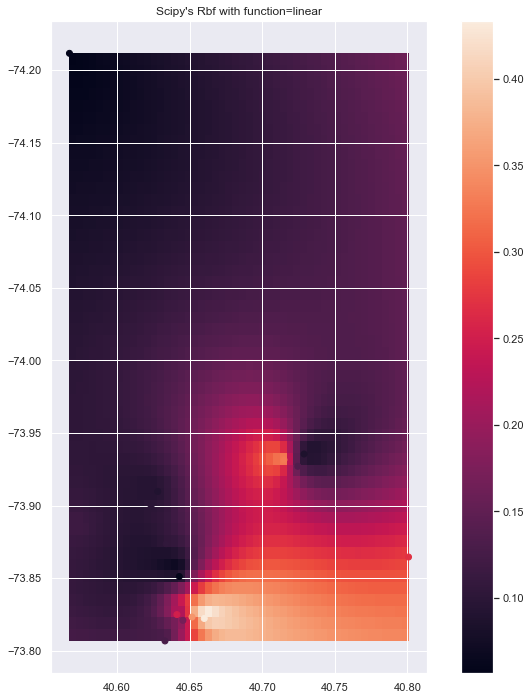

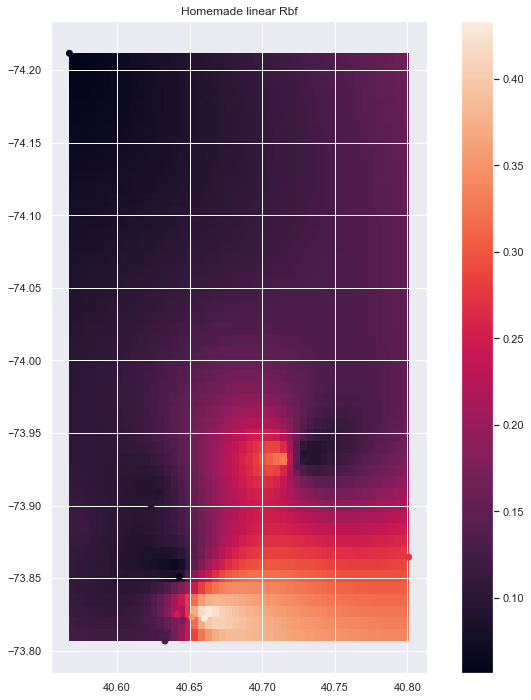

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

def main():
    # Setup: Generate data...
    nx, ny = 50, 50
    x = joined_df['Lat']
    y = joined_df['Long']
    z = joined_df['NC0_fail_overlap_pho']
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    # Calculate IDW
    grid1 = simple_idw(x,y,z,xi,yi)
    grid1 = grid1.reshape((ny, nx))

    # Calculate scipy's RBF
    grid2 = scipy_idw(x,y,z,xi,yi)
    grid2 = grid2.reshape((ny, nx))

    grid3 = linear_rbf(x,y,z,xi,yi)
    grid3 = grid3.reshape((ny, nx))


    # Comparisons...
    plot(x,y,z,grid1)
    plt.title('Homemade IDW')

    plot(x,y,z,grid2)
    plt.title("Scipy's Rbf with function=linear")

    plot(x,y,z,grid3)
    plt.title('Homemade linear Rbf')

    plt.show()

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def linear_rbf(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # Mutual pariwise distances between observations
    internal_dist = distance_matrix(x,y, x,y)

    # Now solve for the weights such that mistfit at the observations is minimized
    weights = np.linalg.solve(internal_dist, z)

    # Multiply the weights for each interpolated point by the distances
    zi =  np.dot(dist.T, weights)
    return zi


def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)


def plot(x,y,z,grid):
    plt.figure(figsize=(12,12))
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()))
    plt.scatter(x,y,c=z)
    plt.colorbar()

main()